# Zeitdiskrete Systeme im Zeitbereich

In diesem Notebook wird gezeigt, wie sich einfache zeitdiskrete Filter im Zeitbereich verhalten und wie man ihre Reaktion auf Zeitsignale darstellen kann.

In [1]:
from __future__ import print_function, division
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
import dsp_fpga_lib as dsp
    
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.signal as sig

import dsp_fpga_lib as dsp
dsp.versions() # print versions 
#plt.rcParams.update({'figure.figsize': (6,4)}) # change figure size in inches

Python version: 3.5.6
Numpy: 1.15.2
Scipy: 1.1.0
Matplotlib: 2.2.2 module://ipykernel.pylab.backend_inline


## Zwei LTI-Systeme

Das folgende Bild zeigt den Signalflussgraphen eines Moving Average (MA) Filters (gleitender Mittelwert) mit der Ordnung $N=4$ und der Länge $L=5$. Die Länge ist dabei die Anzahl der Taps und entspricht der Länge der Impulsantwort.

![LTI-MA.png](../_img/LTI-MA.png)

Das folgende Bild zeigt ein Filter, das aus zwei kaskadierten MA-Filtern jeweils mit der Ordnung 2 besteht. Die Gesamtordnung des Filters ist $N=4$, die Länge ist $L=5$.

![LTI-kask_MA.png](../_img/LTI-kask_MA.png)

Überlegen Sie, wie die Impulsantworten beider Systeme aussehen - sind sie identisch? Wir werden das im Folgenden ausprobieren.

### Definition des Filters über seine Impulsantwort
In der nächsten Codezelle definieren wir das Filter über seine Impulsantwort (das geht natürlich nur bei FIR-Filtern). Die Impulsantwort des kaskadierten Filters erhalten wir, indem wir die Impulsantwort des ersten Teilfilters mit der des zweiten Teilfilters falten:

In [2]:
h = np.ones(5) # MA-filter, N = 4, L = 5
#h = np.convolve([1,1,1],[1,1,1]) # Cascade two MA-filters, each with N = 2

## Impulsantwort des Filters
Die Impulsantwort können wir direkt plotten:

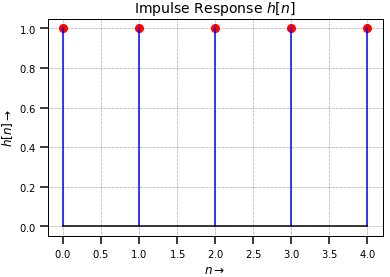

In [3]:
plt.figure()
plt.stem(range(len(h)), h, 'b-', 'ro', 'k') # plot h[n] with blue stems, red markers, black baseline
plt.xlabel(r'$n \rightarrow$'); plt.ylabel(r'$h[n] \rightarrow$');
plt.title(r'Impulse Response $h[n]$');

## Zeitdiskrete und "analoge Signale"
Jetzt definieren wir ein einfaches sinusförmiges Testsignal $x[n]$ für unsere Filter, ausgehend von einem "analogen" Signal $x(t)$. Der Gleichanteil soll das Nutzsignal sein, der Wechselanteil eine Brummstörung (50 Hz) repräsentieren.

  n :    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |
x[n]: 2.00 | 1.50 | 1.00 | 1.50 | 2.00 | 1.50 | 1.00 | 1.50 |

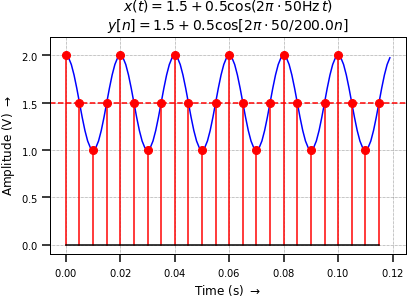

In [4]:
Ts = 1/200.0     # sampling period
fsig = 50.0      # signal frequency
phi0  = 0        # signal initial phase
tstep = 1e-3     # time step for "analog" signal
Tmax = 6.0/fsig  # timespan for 6 signal periods 
N_Ts = Tmax / Ts # number of samples in Tmax
# -- Calculate time-vectors and input signals ---
t = np.arange(0,Tmax,tstep)  # time t
n = np.arange(0,round(N_Ts)) # sample n (start,stop,step)
xt = 1.5 + 0.5*np.cos(2.0*np.pi*fsig*t + phi0) # x(t).
xn = 1.5 + 0.5*np.cos(2.0*np.pi*fsig*n*Ts + phi0) # x[n]

plt.figure() 
plt.xlabel(r'Time (s) $\rightarrow$')
plt.ylabel(r'Amplitude (V) $\rightarrow$')
plt.title('$x(t) = 1.5 + 0.5 \cos(2 \pi \cdot 50 \mathrm{Hz}\, t)$\n\
$y[n] = 1.5 + 0.5 \cos[2 \pi \cdot 50 / %.1f n]$'%(1./Ts))
#
plt.plot(t, xt, 'b-') # x(t) with blue line
plt.stem(n*Ts, xn, 'r-', 'ro', 'k') # x[n], red markers + stems, black baseline
plt.ylim(-0.1, 2.2)   # set y-limits to ymin, ymax
# horizontal line (relative x-coordinates):
plt.axhline(1.5, xmin=0, xmax=1, linestyle='--') 
plt.subplots_adjust(top=0.88,right=0.95)
# generate table
print('  n :', end="")
for i in range(8): print('{:5d} |'.format(i), end="")
print('\nx[n]:', end="")
for i in range(8): print('{0:5.2f} |'.format(xn[i]), end="")

## Gefiltertes Signal im Zeitbereich
Um das gefilterte Ausgangssignal $y[n]$ zu berechnen, falten wir das Testsignal $x[n]$ mit der Impulsantwort des Filters $h[n]$:


y[n]: 2.00 3.50 4.50 6.00 8.00 7.50 7.00 7.50

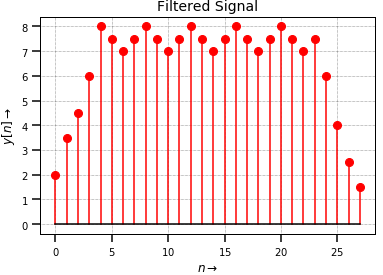

In [5]:
plt.figure()
yn = np.convolve(xn,h) # convolve signal and response
print('\ny[n]:', end="")
for i in range(8): print('{0:5.2f}'.format(yn[i]), end="")
plt.stem(range(len(yn)), yn, 'r-', 'ro', 'k') # y[n]
plt.xlabel(r'$n \rightarrow$'); plt.ylabel(r'$y[n] \rightarrow$')
plt.title('Filtered Signal');

**Aufgaben:**
- Warum ist die Länge eines FIR-Filters immer genau eins größer als die Ordnung? Betrachten Sie dazu die obigen Signalflussgraphen.
- Experimentieren Sie mit verschiedenen Längen für das MA-Filter, interpretieren Sie die Ergebnisse. Was passiert beim MA-Filter der Ordnung $N=3$?
- Warum ist die Höhe des Gleichanteils am Ausgang anders als am Eingang? Korrigieren Sie den Skalierungsfehler im Code.
- Schätzen Sie die Unterdrückung des Gleichsignals aus den Simulationsplots ab.

***
**Copyright**

(c) 2016 - 2019 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp_fpga "Digitale Signalverarbeitung auf FPGAs"

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing auf FPGAs - Vorlesungsunterlagen mit Simulationsbeispielen, 2019*.